# Gaia data for DP0.3 asteroids

By Melissa & Jake

From the Gaia Sprint Day, Feb 2024

Weekly 2024_04

## Import packages and establish TAP connections

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pyvo
from lsst.rsp import get_tap_service

In [2]:
gaia_tap_url = 'https://gea.esac.esa.int/tap-server/tap'
gaia_tap = pyvo.dal.TAPService(gaia_tap_url)
assert gaia_tap is not None
assert gaia_tap.baseurl == gaia_tap_url

In [3]:
lsst_tap = get_tap_service("ssotap")
assert lsst_tap is not None

## Access Gaia data

### Explore what is available

In [21]:
# query = "SELECT * FROM tap_schema.schemas"
# results = gaia_tap.run_sync(query).to_table()
# results

Below, tried to explore gaiadr3 to see which tables are available but
the `schema_name` is type object and I can't figure out how
to make this query work. This is how it was done in DP03_02 NB.

Used the Portal instead to explore TAP tables.

In [22]:
# query = "SELECT * FROM tap_schema.tables " \
#         "WHERE tap_schema.tables.schema_name = 'gaiadr3'"
# results = gaia_tap.search(query).to_table()
# results

Get 10000 solar system objects.

In [23]:
query = "SELECT TOP 10000 denomination, num_observations FROM gaiadr3.sso_orbits"
pd_gaia = gaia_tap.search(query).to_table().to_pandas()

After some exploring in the portal, figured out that `denomination` is
the MPC designation. 

The standard format for MPC designation is the year, then a space,
and then an identifier that is several characters, captial letters and numbers.

Some Gaia tables use underscores instead of spaces and/or lower-case letters
instead of capital letters. 

Define:
 * `mpc_desig1` : spaces and capital letters
 * `mpc_desig2` : spaces and lower-case letters

In [24]:
pd_gaia['mpc_desig1'] = pd_gaia['denomination'].str.replace('_', ' ').str.upper()
pd_gaia['mpc_desig2'] = pd_gaia['denomination'].str.replace('_', ' ')

In [25]:
pd_gaia

,denomination,num_observations,mpc_desig1,mpc_desig2
0,2001_sc288,149,2001 SC288,2001 sc288
1,haldane,75,HALDANE,haldane
2,2000_so179,213,2000 SO179,2000 so179
3,2000_uk45,69,2000 UK45,2000 uk45
4,spirit,199,SPIRIT,spirit
...,...,...,...,...
9995,2004_xe32,129,2004 XE32,2004 xe32
9996,2004_dz14,63,2004 DZ14,2004 dz14
9997,2001_bn33,85,2001 BN33,2001 bn33
9998,2005_us107,66,2005 US107,2005 us107


## Access DP0.3 data

Get 10000 ojbects that have at least 10 observations and an H magnitude
less than 21 mag (bright).

Bright objects are more likely to have been detected by Gaia.

In [26]:
query = "SELECT TOP 10000 mpc.mpcDesignation, mpc.mpcH, sso.numObs, sso.ssObjectId "\
        "FROM dp03_catalogs_10yr.MPCORB AS mpc "\
        "JOIN dp03_catalogs_10yr.SSObject AS sso "\
        "ON mpc.ssObjectId = sso.ssObjectId "\
        "WHERE sso.numObs > 10 AND mpc.mpcH < 21"
pd_lsst = lsst_tap.search(query).to_table().to_pandas()

Also create `mpc_desig1` with all capital letters.

In [27]:
pd_lsst['mpc_desig1'] = pd_lsst['mpcDesignation'].str.upper()

In [28]:
pd_lsst

,mpcDesignation,mpcH,numObs,ssObjectId,mpc_desig1
0,S101q3vm,20.580000,45,-9223370383071521539,S101Q3VM
1,S1008gC7,20.670000,22,-9223366535898786459,S1008GC7
2,2022 PV1,15.190000,212,-9223365099512229794,2022 PV1
3,S101lM1o,20.580000,28,-9223364443532342230,S101LM1O
4,2004 PX6,16.730000,211,-9223354132337021199,2004 PX6
...,...,...,...,...,...
9995,2010 GC6,15.780000,279,-9178627963286576493,2010 GC6
9996,2004 YP2,16.139999,234,-9178627269070829876,2004 YP2
9997,2002 UW4,18.430000,228,-9178626036298106887,2002 UW4
9998,S1001UmE,15.020000,262,-9178620883575921398,S1001UME


## Match Gaia & DP0.3 data using designations

In [31]:
for i in range(len(pd_lsst)):
    str1 = pd_lsst['mpc_desig1'][i]
    tx = np.where(str1 == pd_gaia['mpc_desig1'][:])[0]
    if len(tx) > 0:
        print('match ', 
              pd_gaia['denomination'][tx[0]], 
              pd_gaia['mpc_desig1'][tx[0]], 
              pd_gaia['num_observations'][tx[0]], '   ',
              pd_lsst['mpc_desig1'][i],
              pd_lsst['numObs'][i],
              pd_lsst['ssObjectId'][i])

match  2002_qj6 2002 QJ6 184     2002 QJ6 293 -9220246324893037857
match  2000_tb4 2000 TB4 98     2000 TB4 399 -9217496323063234344
match  1999_jv5 1999 JV5 35     1999 JV5 340 -9215133665071394313
match  2000_ss3 2000 SS3 341     2000 SS3 298 -9215008618020954753
match  2002_gt8 2002 GT8 79     2002 GT8 217 -9213123882490191216
match  1999_rd1 1999 RD1 119     1999 RD1 219 -9207897402210044224
match  2001_sd1 2001 SD1 133     2001 SD1 226 -9204336110659258408
match  1132_t-1 1132 T-1 242     1132 T-1 249 -9203773188588633326
match  2002_pu1 2002 PU1 102     2002 PU1 350 -9193139087942386641
match  1999_xq1 1999 XQ1 174     1999 XQ1 222 -9192495980634424459
match  1999_cv1 1999 CV1 201     1999 CV1 153 -9191356645823939974
match  2006_bd1 2006 BD1 206     2006 BD1 288 -9185586931848576327
match  1999_rd1 1999 RD1 119     1999 RD1 314 -9183694582524310840
match  1998_hf3 1998 HF3 257     1998 HF3 229 -9183137241548068028
match  1998_xe6 1998 XE6 119     1998 XE6 362 -918201340504663412

Choose one to plot a light curve for.

In [32]:
my_denomination = '2002_qj6'
my_mpc_desig1 = '2002 QJ6'
my_mpc_desig2 = '2002 qj6'
my_ssObjectId = '-9220246324893037857'

### Get Gaia photometry.

Apparent g-band magnitudes and dates from `sso_observation`.

In [33]:
query = "SELECT epoch, epoch_utc, g_mag "\
        "FROM gaiadr3.sso_observation "\
        "WHERE denomination = '" + my_mpc_desig2 + "'"
pd_gaia_obs = gaia_tap.search(query).to_table().to_pandas()

Convert TCB times to JD and MJD.

From <a href="https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_sso_tables/ssec_dm_sso_observation.html">the documentation</a>, 
`epoch` is the Gaia-centric epoch TCB(Gaia).

The conversion is JD = TCB + 2455197.5 (day).

In [34]:
pd_gaia_obs['epoch_jd'] = pd_gaia_obs['epoch_utc'] + 2455197.5
pd_gaia_obs['epoch_mjd'] = pd_gaia_obs['epoch_utc'] + 55197.5

In [35]:
pd_gaia_obs

,epoch,epoch_utc,g_mag,epoch_jd,epoch_mjd
0,2122.405405,2122.404396,20.505686,2.457320e+06,57319.904396
1,2122.405461,2122.404452,20.505686,2.457320e+06,57319.904452
2,2122.405517,2122.404508,20.505686,2.457320e+06,57319.904508
3,2122.405573,2122.404564,20.505686,2.457320e+06,57319.904564
4,2122.655536,2122.654527,20.520324,2.457320e+06,57320.154527
...,...,...,...,...,...
179,2656.708497,2656.707468,20.134015,2.457854e+06,57854.207468
180,2656.708553,2656.707525,20.134015,2.457854e+06,57854.207525
181,2656.708610,2656.707581,20.134015,2.457854e+06,57854.207581
182,2656.708666,2656.707637,20.134015,2.457854e+06,57854.207637


### Get LSST photometry.

From `diaSource`.

In [36]:
query = "SELECT midpointMjdTai, mag, band "\
        "FROM dp03_catalogs_10yr.DiaSource "\
        "WHERE ssObjectId = " + my_ssObjectId
pd_lsst_obs = lsst_tap.search(query).to_table().to_pandas()

In [37]:
pd_lsst_obs

,midpointMjdTai,mag,band
0,63834.27803,19.952999,r
1,60604.03635,20.589001,i
2,62969.08553,21.058001,g
3,63375.32592,20.139999,i
4,63375.32781,20.107000,i
...,...,...,...
288,63786.39825,20.924000,r
289,62910.24143,19.931000,r
290,63852.22766,19.318001,i
291,61502.27304,19.767000,i


## Plot the combined light curve

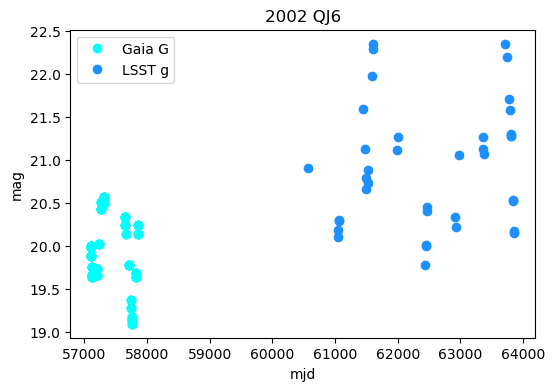

In [38]:
fig = plt.figure(figsize=(6, 4))
plt.plot(pd_gaia_obs['epoch_mjd'], pd_gaia_obs['g_mag'], 
         'o', color='cyan', label='Gaia G')
fx = np.where(pd_lsst_obs['band'][:] == 'g')[0]
plt.plot(pd_lsst_obs['midpointMjdTai'][fx], pd_lsst_obs['mag'][fx], 
         'o', color='dodgerblue', label='LSST g')
plt.legend(loc='upper left')
plt.xlabel('mjd')
plt.ylabel('mag')
plt.title(my_mpc_desig1)
plt.show()

## Stretch goals

 * figure out how to get phase of Gaia observations
 * plot phase curve corrected light curve
 * explore population matches like Jake did